In [ ]:
%reload_ext autoreload
%autoreload 2

import os
import sys
from re import match
from time import strftime, gmtime, sleep

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
import boto3
import sagemaker
from sagemaker.tensorflow.estimator import TensorFlow
from sagemaker.tensorflow import TensorFlowModel
from sagemaker.tuner import (
    ContinuousParameter,
    IntegerParameter,
    CategoricalParameter,
    HyperparameterTuner,
)
from tqdm import tqdm
import numpy as np
from hydra import compose, initialize, core
from omegaconf import OmegaConf

import matplotlib.pyplot as plt

sys.path.append(os.path.dirname(os.getcwd()))
from src import model_utils

## Hydra

In [4]:
core.global_hydra.GlobalHydra.instance().clear()
initialize(
    version_base="1.2",
    config_path="../src/config",
    job_name="vision_transformer_notebook",
)
config = OmegaConf.to_container(compose(config_name="main"), resolve=True)

## S3

In [5]:
s3 = boto3.client("s3")

train_val_path = {
    "train": sagemaker.inputs.TrainingInput(
        s3_data=f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/train',
        distribution="FullyReplicated",
        s3_data_type="S3Prefix",
    ),
    "val": sagemaker.inputs.TrainingInput(
        s3_data=f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/val',
        distribution="FullyReplicated",
        s3_data_type="S3Prefix",
    ),
}
train_val_path

{'train': <sagemaker.inputs.TrainingInput at 0x7f17684774f0>,
 'val': <sagemaker.inputs.TrainingInput at 0x7f17684775b0>}

## SageMaker

In [6]:
sagemaker_session = sagemaker.Session(default_bucket=config["s3_bucket"])
sagemaker_session

sm_boto3 = boto3.client("sagemaker")
role = sagemaker.get_execution_role()

## Vision Transformer

Testing locally:

In [ ]:
vit_testing_estimator = TensorFlow(
    # Entry point
    entry_point=config["vision_transformer"]["entry_point"],
    source_dir=config["src_dir_path"],
    py_version=config["py_version"],
    framework_version=config["framework_version"],
    # Sagemaker
    role=role,
    instance_type="local",
    instance_count=config["vision_transformer"]["instance_count"],
    model_dir=config["model_dir"],
    code_location=config["code_location"],
    output_path=config["output_path"],
    volume_size=config["volume_size"],
    hyperparameters={
        # Data augmentation parameters
        "random_flip_mode": "horizontal",
        "random_rotation_factor": 0.15,
        "random_contrast_factor": 0.15,
        "random_zoom_height_factor": 0.15,
        "random_zoom_width_factor": 0.15,
        # Architecture parameters
        "spt_patch_size": 64,
        "spt_projection_dim": 32,
        "transformer_num_heads": 1,
        "transformer_num_layers": 1,
        "transformer_dropout_rate": 0.5,
        "transformer_mlp_multiple_0": 1,
        "dense_num_layers": 1,
        "dense_units_0": 8,
        "dense_units_1": 8,
        "dense_units_2": 8,
        "dense_dropout_rate": 0.3,
        # Optimization, loss, and fit parameters
        "adam_initial_lr": 1e-3,
        "adam_beta_1": 0.9,
        "adam_beta_2": 0.999,
        "adam_clipnorm": 0.1,
        "loss_gamma": 0.0,
        "loss_alpha": 0.0,
        "fit_epochs": 2,
        # Local mode
        "test_mode": 1,
        "distributed_multi_worker": 0,
        "use_focal_loss": 0,
    },
)

vit_testing_estimator.fit(train_val_path)

In [17]:
!sudo rm -rf /tmp/tmp*

### Hyerperparameter Tuning

In [28]:
vit_tf_estimator = TensorFlow(
    # Entry point
    entry_point=config["vision_transformer"]["entry_point"],
    source_dir=config["src_dir_path"],
    py_version=config["py_version"],
    framework_version=config["framework_version"],
    # Sagemaker
    role=role,
    instance_type=config["vision_transformer"]["instance_type"],
    instance_count=config["vision_transformer"]["instance_count"],
    model_dir=config["model_dir"],
    code_location=config["code_location"],
    output_path=config["output_path"],
    volume_size=config["volume_size"],
    base_job_name=config["vision_transformer"]["base_job_name"],
    sagemaker_session=sagemaker_session,
    # Distributed
    distribution={"multi_worker_mirrored_strategy": {"enabled": True}},
    # # Spot training
    # max_run=config['max_run'],
    # max_wait=config['max_run'], # Equal or greater than max_run
    # max_retry_attempts=config['max_retry_attempts'],
    # use_spot_instances=config['use_spot_instances'],
    # checkpoint_s3_uri=os.path.join(config['checkpoint_s3_uri'], 'fine_tune'),
    hyperparameters={
        "test_mode": 0,
        "distributed_multi_worker": 1,
        "use_focal_loss": 0,
    },
)
vit_tf_estimator

In [29]:
vit_search_space = {
    # Data augmentation parameters
    "random_contrast_factor": ContinuousParameter(min_value=0.1, max_value=1.0),
    "random_flip_mode": CategoricalParameter(
        values=["horizontal", "vertical", "horizontal_and_vertical"]
    ),
    "random_rotation_factor": ContinuousParameter(min_value=0.1, max_value=0.7),
    "random_zoom_height_factor": ContinuousParameter(min_value=0.1, max_value=0.7),
    "random_zoom_width_factor": ContinuousParameter(min_value=0.1, max_value=0.7),
    # Architecture parameters
    "spt_patch_size": IntegerParameter(min_value=8, max_value=32),
    "spt_projection_dim": CategoricalParameter(values=[256, 512, 768]),
    "transformer_num_heads": IntegerParameter(min_value=8, max_value=12),
    "transformer_num_layers": IntegerParameter(min_value=8, max_value=12),
    "transformer_dropout_rate": ContinuousParameter(min_value=0.1, max_value=0.5),
    "transformer_mlp_multiple_0": IntegerParameter(min_value=2, max_value=4),
    "dense_num_layers": IntegerParameter(min_value=2, max_value=3),
    "dense_units_0": IntegerParameter(min_value=128, max_value=1024),
    "dense_units_1": IntegerParameter(min_value=128, max_value=1024),
    "dense_units_2": IntegerParameter(min_value=128, max_value=1024),
    "dense_dropout_rate": ContinuousParameter(min_value=0.1, max_value=0.5),
    # Optimization, loss, and fit parameters
    "adam_initial_lr": ContinuousParameter(
        min_value=1e-4, max_value=1e-1
    ),  # Smaller learning rate since large gradient updates may lead to overfitting
    "adam_beta_1": ContinuousParameter(min_value=0.7, max_value=0.999),
    "adam_beta_2": ContinuousParameter(min_value=0.8, max_value=0.999),
    "adam_clipnorm": ContinuousParameter(min_value=1e-2, max_value=1.0),
    "loss_alpha": ContinuousParameter(0.1, 0.9),
    "loss_gamma": ContinuousParameter(0.5, 2.0),
    "fit_epochs": IntegerParameter(min_value=10, max_value=20),
}

vit_objective_metric_name = "accuracy"
vit_objective_type = "Maximize"
vit_metric_definitions = [
    {
        "Name": vit_objective_metric_name,
        "Regex": "Best validation accuracy: ([0-9\\.]+)",
    }
]

In [44]:
vit_hpo_tuner = HyperparameterTuner(
    estimator=vit_tf_estimator,
    objective_metric_name=vit_objective_metric_name,
    hyperparameter_ranges=vit_search_space,
    metric_definitions=vit_metric_definitions,
    strategy="Bayesian",
    objective_type=vit_objective_type,
    max_jobs=15,
    max_parallel_jobs=1,
    base_tuning_job_name=config["vision_transformer"]["base_tuning_job_name"],
)

In [45]:
vit_hpo_tuner.fit(train_val_path)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker:Creating hyperparameter tuning job with name: vit-hpo-230815-1836


...............................................................................................................................................................................................

Visualization:

In [5]:
vit_hpo_analytics = sagemaker.HyperparameterTuningJobAnalytics(
    vit_hpo_tuner.latest_tuning_job.name
)

vit_hpo_results = vit_hpo_analytics.dataframe()

vit_hpo_results.sort_values("FinalObjectiveValue", ascending=False).head(10)

adam_beta_1  adam_beta_2  adam_clipnorm  adam_initial_lr  \
10     0.994448     0.995604       0.214820         0.000104   
7      0.925705     0.996081       0.015768         0.000216   
6      0.934412     0.995802       0.017377         0.006857   
8      0.998736     0.980190       0.081659         0.027883   
4      0.913699     0.996854       0.102326         0.002037   
0      0.947438     0.988113       0.067891         0.007369   
1      0.999000     0.994836       0.050892         0.065817   
5      0.866078     0.921323       0.047346         0.000250   
13     0.853629     0.995690       0.318502         0.000265   
14     0.986822     0.991600       0.233496         0.011098   

    dense_dropout_rate  dense_num_layers  dense_units_0  dense_units_1  \
10            0.186689               3.0          527.0          566.0   
7             0.251202               1.0          885.0          649.0   
6             0.202125               3.0          259.0          768.0   
8             0.488500               2.0          989.0          606.0   
4             0.192002               1.0          550.0          552.0   
0             0.384652               1.0          845.0          885.0   
1             0.414731               1.0          426.0          385.0   
5             0.482307               3.0          163.0          164.0   
13            0.201703               3.0          277.0          954.0   
14            0.257258               3.0          841.0          403.0   

    dense_units_2  fit_epochs  ...  transformer_mlp_multiple_0  \
10          902.0        11.0  ...                         4.0   
7           993.0        12.0  ...                         4.0   
6           594.0        20.0  ...                         2.0   
8           197.0        14.0  ...                         4.0   
4           816.0        14.0  ...                         4.0   
0           488.0        13.0  ...                         3.0   
1           729.0        15.0  ...                         4.0   
5           644.0        19.0  ...                         3.0   
13          448.0        12.0  ...                         3.0   
14          516.0        16.0  ...                         2.0   

    transformer_mlp_multiple_1  transformer_num_heads transformer_num_layers  \
10                         2.0                   12.0                   12.0   
7                          4.0                    8.0                    8.0   
6                          3.0                    9.0                   11.0   
8                          4.0                   12.0                    9.0   
4                          4.0                   12.0                   12.0   
0                          2.0                   12.0                    8.0   
1                          3.0                    8.0                    8.0   
5                          3.0                   11.0                   12.0   
13                         3.0                   10.0                   11.0   
14                         2.0                   12.0                    9.0   

                     TrainingJobName  TrainingJobStatus  FinalObjectiveValue  \
10  vit-hpo-230815-1836-005-7b11d1ba          Completed             0.295633   
7   vit-hpo-230815-1836-008-1bb4f91d          Completed             0.262598   
6   vit-hpo-230815-1836-009-17386a3f          Completed             0.251400   
8   vit-hpo-230815-1836-007-57f3d721          Completed             0.251400   
4   vit-hpo-230815-1836-011-76e89271          Completed             0.241881   
0   vit-hpo-230815-1836-015-74801e23          Completed             0.224524   
1   vit-hpo-230815-1836-014-d0db43ec          Completed             0.224524   
5   vit-hpo-230815-1836-010-622d901f          Completed             0.224524   
13  vit-hpo-230815-1836-002-df3e971d          Completed             0.224524   
14  vit-hpo-230815-1836-001-11e005d6          Completed             0.224524

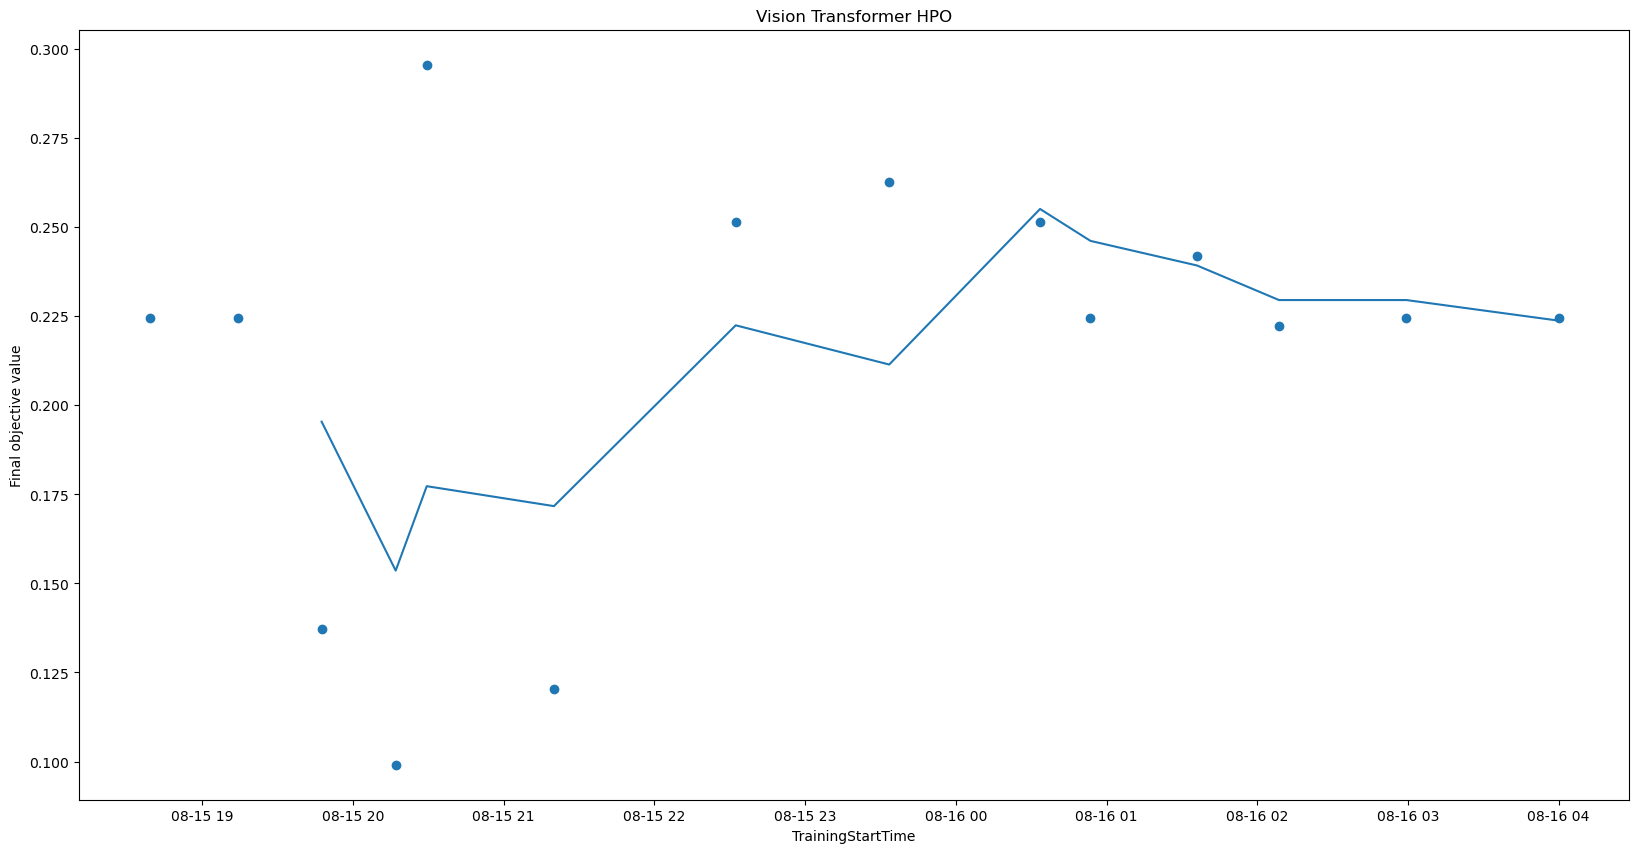

In [6]:
plt.figure(figsize=(20, 10))
# Remove missing values in TrainingStartTime
vit_hpo_results.dropna(subset=["FinalObjectiveValue"], inplace=True)
# Sort by TrainingStartTime
vit_hpo_results.sort_values("TrainingStartTime", inplace=True)
plt.scatter(
    vit_hpo_results["TrainingStartTime"], vit_hpo_results["FinalObjectiveValue"]
)
plt.plot(
    vit_hpo_results["TrainingStartTime"],
    vit_hpo_results["FinalObjectiveValue"].rolling(3).mean(),
)
plt.xlabel("TrainingStartTime")
plt.ylabel("Final objective value")
plt.title("Vision Transformer HPO")
plt.show();

## Hyperparameter Visualization

In [ ]:
# List of hyperparameters
params = list(
    set(vit_hpo_results.columns)
    - set(
        [
            "TrainingJobName",
            "TrainingJobStatus",
            "TrainingStartTime",
            "TrainingEndTime",
            "TrainingElapsedTimeSeconds",
            "FinalObjectiveValue",
        ]
    )
)
params.sort()

cat_params = ["spt_projection_dim", "random_flip_mode"]
num_params = list(set(params) - set(cat_params))

# Visualizer
viz = model_utils.TuningVisualizer(
    tune_data=vit_hpo_results, cat_params=cat_params, num_params=num_params
)
viz

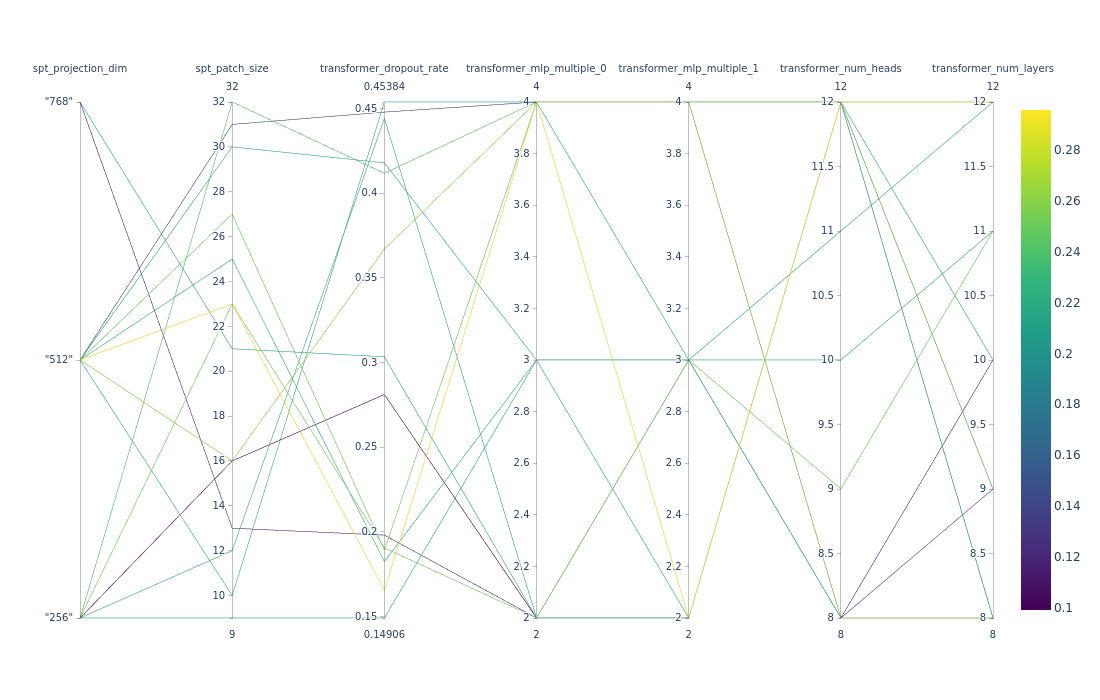

In [8]:
# SPT and Transformer
viz.plot_parallel_coordinate(
    columns=[
        param
        for param in params
        if param.startswith("spt") or param.startswith("transformer")
    ],
    static=True,
    figsize=(1100, 700),
)

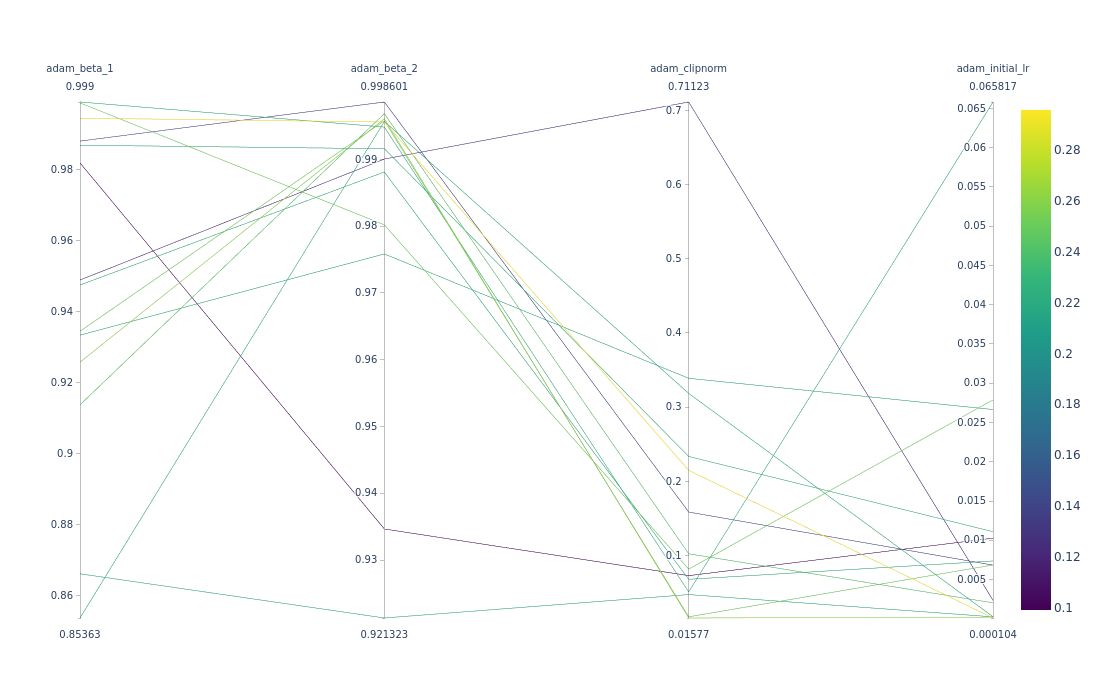

In [9]:
# Optimization
viz.plot_parallel_coordinate(
    columns=[param for param in params if match("^adam", param)],
    static=True,
    figsize=(1100, 700),
)

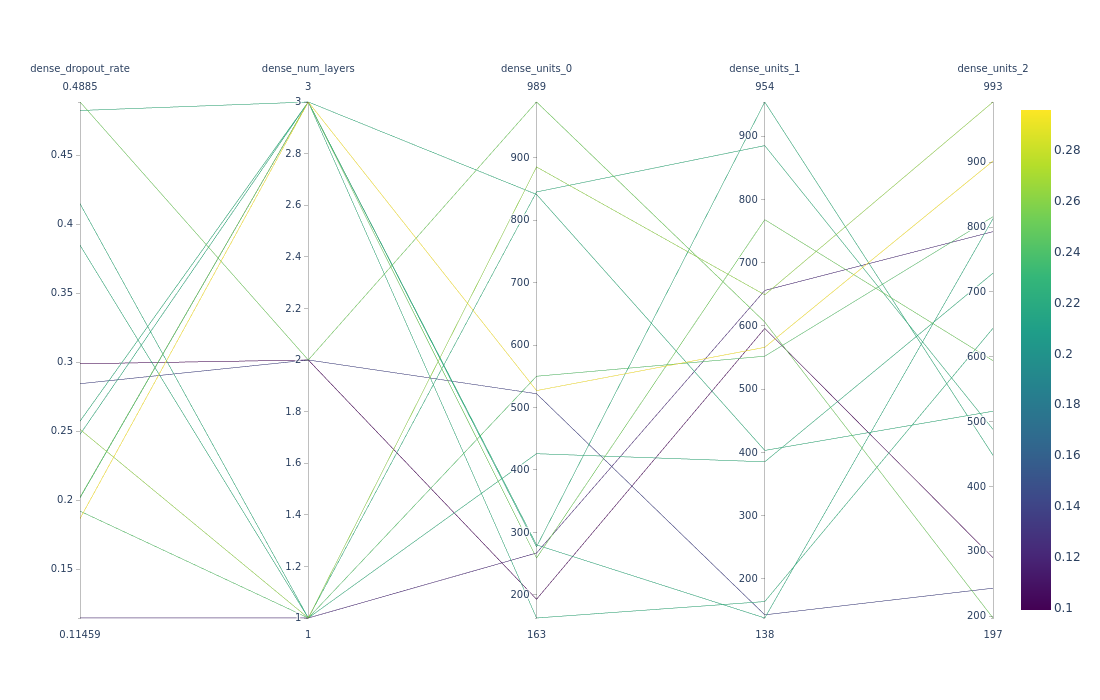

In [10]:
# Dense
viz.plot_parallel_coordinate(
    columns=[param for param in params if match("^dense", param)],
    static=True,
    figsize=(1100, 700),
)

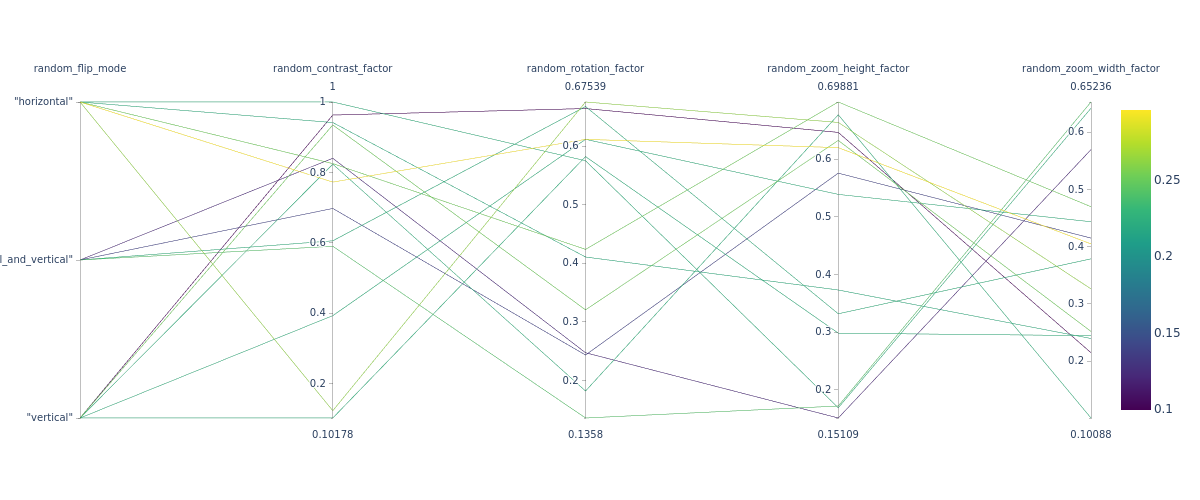

In [13]:
# Data augmentation
viz.plot_parallel_coordinate(
    columns=[param for param in params if match("^random", param)],
    static=True,
    figsize=(1200, 500),
)

## Inference

Deploy best model:

In [14]:
best_model_name = sm_boto3.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=vit_hpo_tuner.latest_tuning_job.name
)["BestTrainingJob"]["TrainingJobName"]

# Obtain s3 path to model artifacts
best_model_s3_path = sm_boto3.describe_training_job(TrainingJobName=best_model_name)[
    "ModelArtifacts"
]["S3ModelArtifacts"]

print(f"Best model artifacts persisted at {best_model_s3_path}")

Best model artifacts persisted at s3://yang-ml-homepartners/scene-classification/models/vit-hpo-230815-1836-005-7b11d1ba/output/model.tar.gz


In [ ]:
best_model = TensorFlowModel(
    model_data=best_model_s3_path,
    role=role,
    framework_version=config["framework_version"],
    code_location=config["code_location"],
    sagemaker_session=sagemaker_session,
)

predictor = best_model.deploy(
    initial_instance_count=1,
    instance_type=config["vision_transformer"]["inference_instance_type"],
    endpoint_name=config["vision_transformer"]["endpoint_name"]
    + "-"
    + strftime("%H-%M-%S", gmtime()),
    container_startup_health_check_timeout=5 * 60,
)

----!

Load train, val, test datasets:

In [ ]:
train_dataset = model_utils.load_dataset(
    dir=train_val_path["train"].config["DataSource"]["S3DataSource"]["S3Uri"],
    batch_size=5,
).prefetch(tf.data.AUTOTUNE)

val_dataset = model_utils.load_dataset(
    dir=train_val_path["val"].config["DataSource"]["S3DataSource"]["S3Uri"],
    batch_size=5,
).prefetch(tf.data.AUTOTUNE)

test_dataset = model_utils.load_dataset(
    dir=f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/test', batch_size=5
).prefetch(tf.data.AUTOTUNE)

2023-08-16 20:09:21.472815: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Make predictions in batches:

In [11]:
train_pred_probs = []
y_train = []
X_train = []
for X_train_tf, y_train_tf in tqdm(train_dataset):
    # Predictions
    train_pred_probs.append(predictor.predict(X_train_tf.numpy())["predictions"])

    # Targets
    y_train.append(tf.math.argmax(y_train_tf, axis=1).numpy())

    # Images
    X_train.append(X_train_tf.numpy())

    sleep(1)

y_train = np.concatenate(y_train, axis=0)
X_train = np.concatenate(X_train, axis=0)
train_pred_probs = np.concatenate(train_pred_probs, axis=0)

100%|██████████| 1426/1426 [1:17:05<00:00,  3.24s/it]


In [9]:
val_pred_probs = []
y_val = []
X_val = []
for X_val_tf, y_val_tf in tqdm(val_dataset):
    # Predictions
    val_pred_probs.append(predictor.predict(X_val_tf.numpy())["predictions"])

    # Targets
    y_val.append(tf.math.argmax(y_val_tf, axis=1).numpy())

    # Images
    X_val.append(X_val_tf.numpy())

    sleep(1)

y_val = np.concatenate(y_val, axis=0)
X_val = np.concatenate(X_val, axis=0)
val_pred_probs = np.concatenate(val_pred_probs, axis=0)

100%|██████████| 358/358 [19:31<00:00,  3.27s/it]


In [9]:
test_pred_probs = []
y_test = []
X_test = []
for X_test_tf, y_test_tf in tqdm(test_dataset):
    # Predictions
    test_pred_probs.append(predictor.predict(X_test_tf.numpy())["predictions"])

    # Targets
    y_test.append(tf.math.argmax(y_test_tf, axis=1).numpy())

    # Images
    X_test.append(X_test_tf.numpy())

    sleep(1)

y_test = np.concatenate(y_test, axis=0)
X_test = np.concatenate(X_test, axis=0)
test_pred_probs = np.concatenate(test_pred_probs, axis=0)

100%|██████████| 186/186 [07:00<00:00,  2.26s/it]


Write numpy probabilities matrices to s3:

In [ ]:
for name, (X, y), predicted_probs in zip(
    ["train", "val", "test"],
    [(X_train, y_train), (X_val, y_val), (X_test, y_test)],
    [train_pred_probs, val_pred_probs, test_pred_probs],
):
    filename = f"vit_{name}.npz"

    np.savez(filename, X=X, y=y, predicted_probs=predicted_probs)

    s3_path = f's3://{config["s3_bucket"]}/{config["s3_key"]}/outputs'
    sagemaker.s3.S3Uploader.upload(filename, s3_path)

    os.remove(filename)

### Error Analysis

Load predictions:

In [7]:
s3_path = f's3://{config["s3_bucket"]}/{config["s3_key"]}/outputs'
local_dir = "temp_data"
os.makedirs(local_dir, exist_ok=True)
data = {}
for name in ["train", "val", "test"]:
    local_path = os.path.join(local_dir, f"vit_{name}.npz")
    sagemaker.s3.S3Downloader.download(
        os.path.join(s3_path, f"vit_{name}.npz"), local_dir
    )

    with open(local_path, "rb") as f:
        dataset = np.load(f)
        data[name] = {
            "X": np.clip(dataset["X"].astype(np.int16), 0, 255),
            "y": dataset["y"],
            "predicted_probs": dataset["predicted_probs"],
        }

    # Remove the local file
    os.remove(local_path)

    print("Finished loading", name)

X_train, y_train, train_predicted_probs = (
    data["train"]["X"],
    data["train"]["y"],
    data["train"]["predicted_probs"],
)
X_val, y_val, val_predicted_probs = (
    data["val"]["X"],
    data["val"]["y"],
    data["val"]["predicted_probs"],
)
X_test, y_test, test_predicted_probs = (
    data["test"]["X"],
    data["test"]["y"],
    data["test"]["predicted_probs"],
)

os.rmdir(local_dir)

Finished loading train
Finished loading val
Finished loading test


Error analyzer:

In [ ]:
error_analyzer = model_utils.ErrorAnalyzer(
    y_true=y_train,
    images=X_train,
    y_pred=train_predicted_probs,
    label_mapping=config["class_label_map"],
)

### Backyard

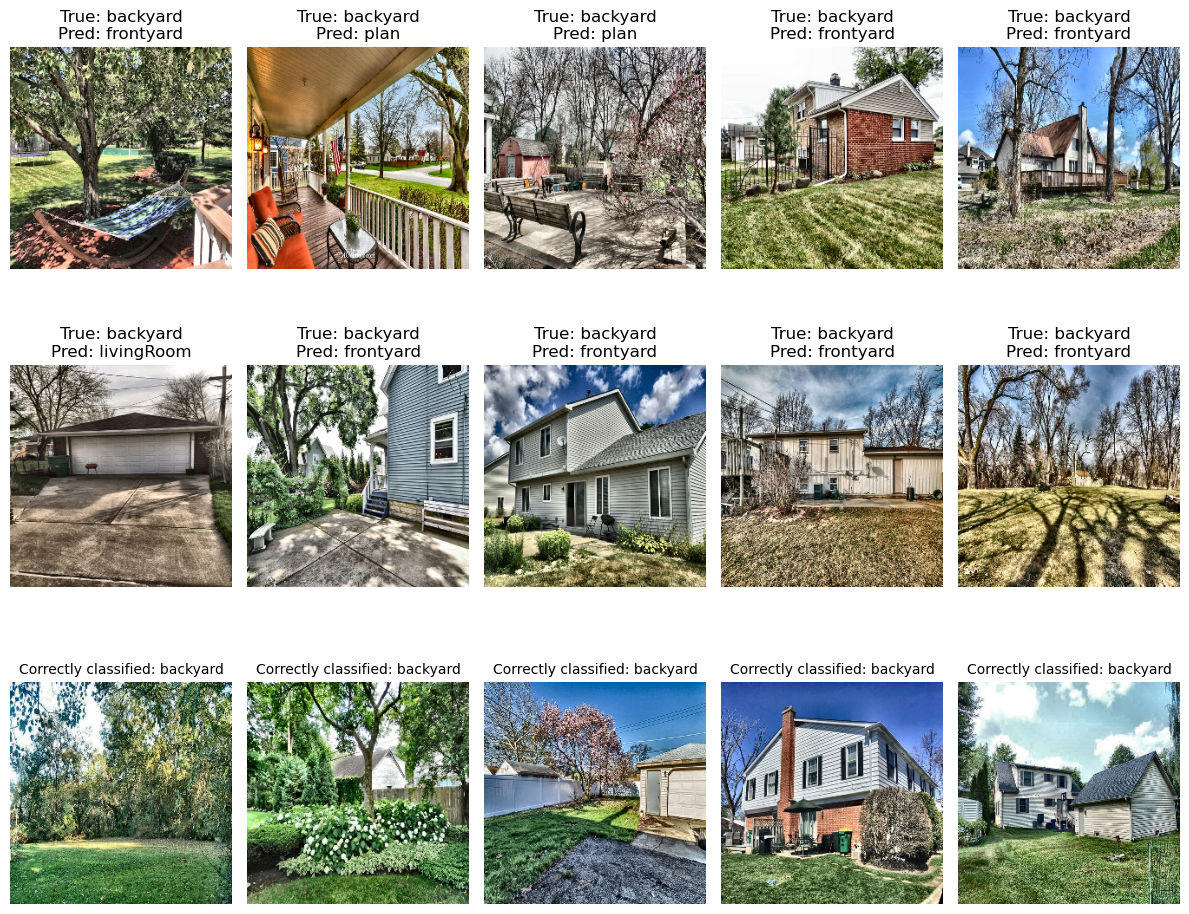

In [33]:
error_analyzer.plot_mis_clf(class_label="backyard", figsize=(12, 10));

### Kitchen

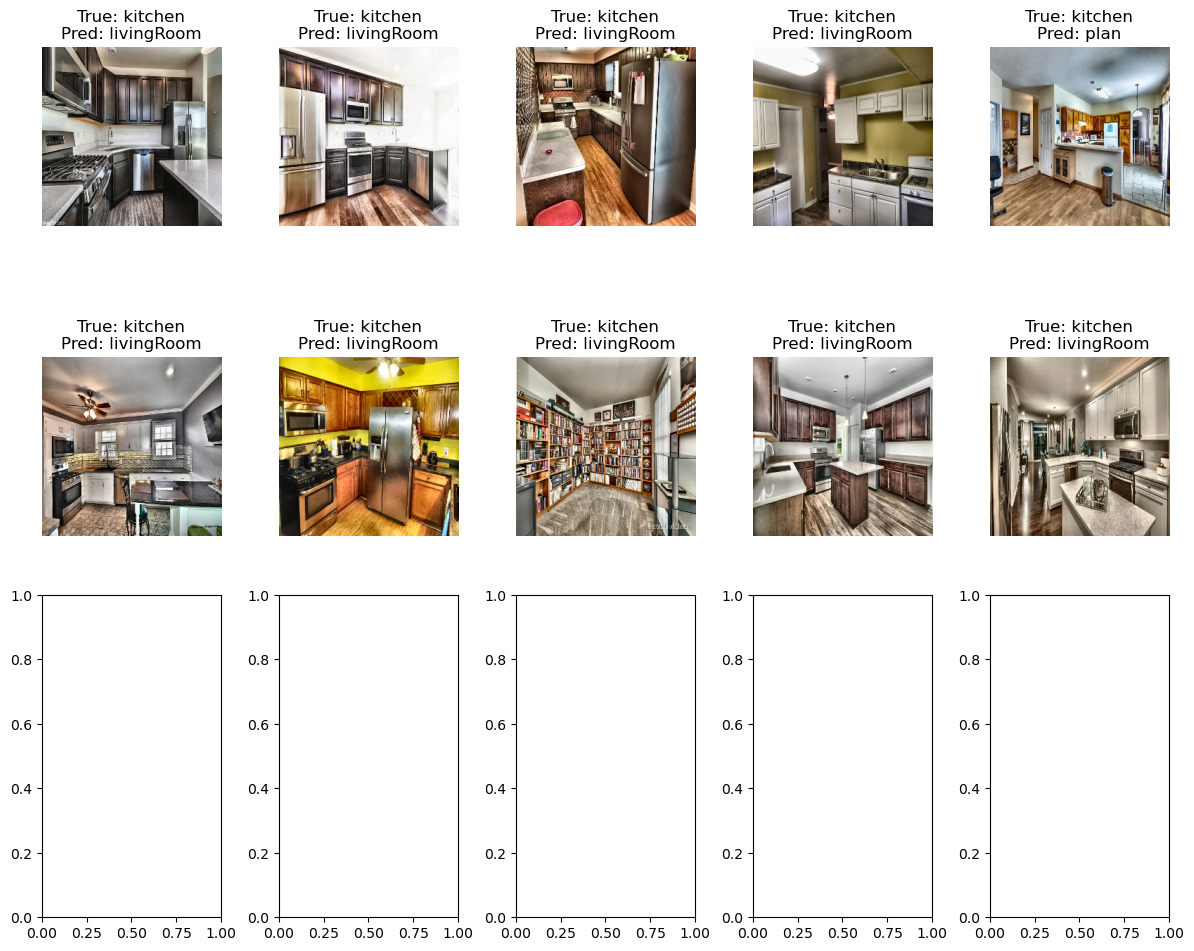

In [34]:
error_analyzer.plot_mis_clf(class_label="kitchen", figsize=(12, 10));

### Dining Room

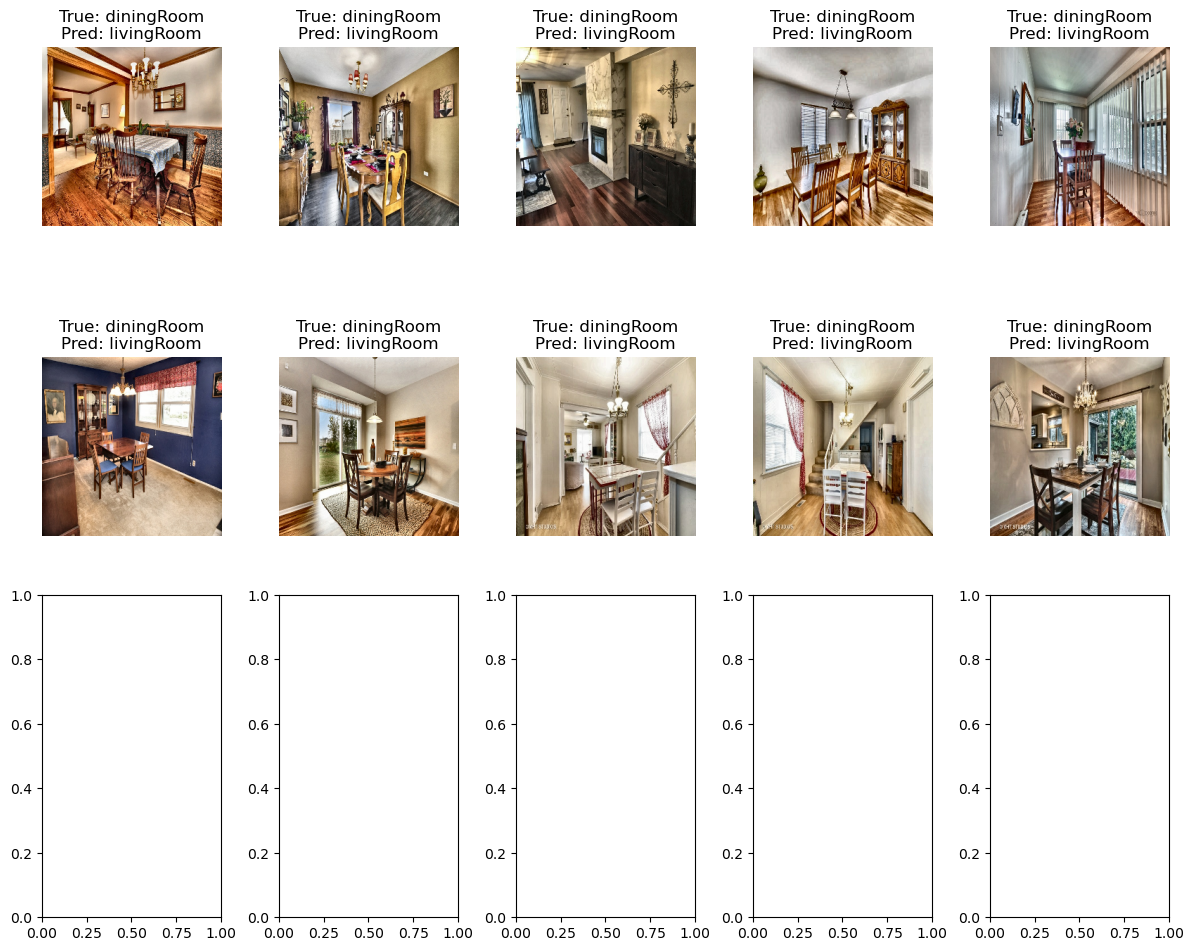

In [18]:
error_analyzer.plot_mis_clf(class_label="diningRoom", figsize=(12, 10));

### Bathroom

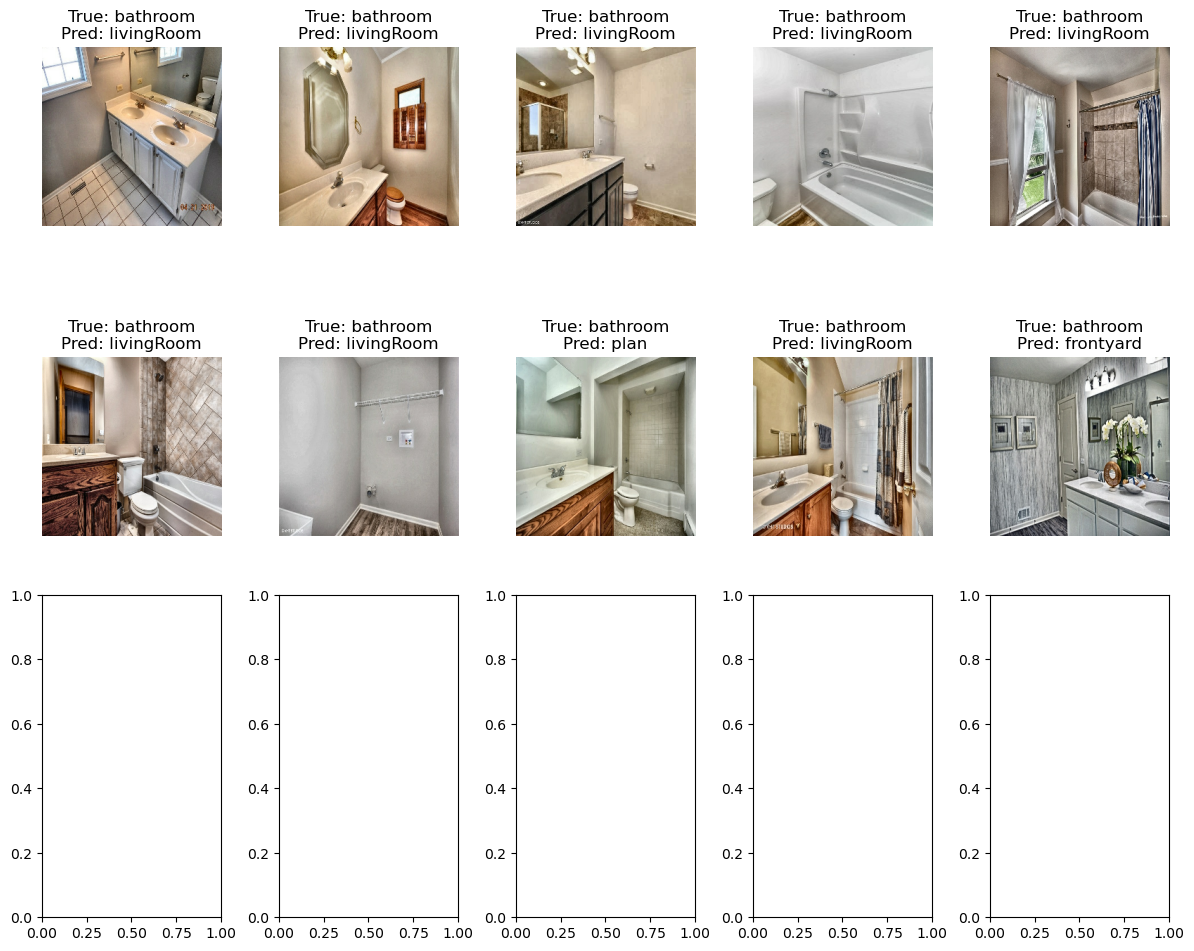

In [35]:
error_analyzer.plot_mis_clf(class_label="bathroom", figsize=(12, 10));

### Classification Report

### Training

In [ ]:
clf_report_train, agg_metrics_train = model_utils.classification_report(
    y_train,
    train_predicted_probs.argmax(axis=1),
    labels=list(config["class_label_map"]),
)

clf_report_train

precision  recall  specificity      f1  geometric_mean  \
backyard       0.0000  0.0000       1.0000  0.0000          0.0000   
bathroom       0.3276  0.8262       0.4291  0.4692          0.5954   
bedroom        0.0000  0.0000       1.0000  0.0000          0.0000   
diningRoom     0.3147  0.4547       0.8911  0.3720          0.6365   
frontyard      0.0382  0.2574       0.8738  0.0665          0.4742   
hall           0.0000  0.0000       1.0000  0.0000          0.0000   
kitchen        0.0000  0.0000       1.0000  0.0000          0.0000   
livingRoom     0.5566  0.4500       0.9534  0.4976          0.6550   
plan           0.0000  0.0000       1.0000  0.0000          0.0000   

            index_balanced_accuracy  support  
backyard                     0.0000    979.0  
bathroom                     0.3686   1795.0  
bedroom                      0.0000    123.0  
diningRoom                   0.3875    706.0  
frontyard                    0.2110    136.0  
hall                         0.0000    116.0  
kitchen                      0.0000    851.0  
livingRoom                   0.4074    820.0  
plan                         0.0000   1601.0

### Validation

In [ ]:
clf_report_val, agg_metrics_val = model_utils.classification_report(
    y_val, val_predicted_probs.argmax(axis=1), labels=list(config["class_label_map"])
)

clf_report_val

precision  recall  specificity      f1  geometric_mean  \
backyard       0.0000  0.0000       1.0000  0.0000          0.0000   
bathroom       0.3145  0.7951       0.4181  0.4508          0.5766   
bedroom        0.0000  0.0000       1.0000  0.0000          0.0000   
diningRoom     0.3167  0.4294       0.8981  0.3645          0.6210   
frontyard      0.0239  0.1765       0.8602  0.0421          0.3896   
hall           0.0000  0.0000       1.0000  0.0000          0.0000   
kitchen        0.0000  0.0000       1.0000  0.0000          0.0000   
livingRoom     0.5562  0.4320       0.9551  0.4863          0.6424   
plan           0.0000  0.0000       1.0000  0.0000          0.0000   

            index_balanced_accuracy  support  
backyard                     0.0000    245.0  
bathroom                     0.3450    449.0  
bedroom                      0.0000     31.0  
diningRoom                   0.3675    177.0  
frontyard                    0.1414     34.0  
hall                         0.0000     30.0  
kitchen                      0.0000    213.0  
livingRoom                   0.3910    206.0  
plan                         0.0000    401.0

### Test

In [ ]:
clf_report_test, agg_metrics_test = model_utils.classification_report(
    y_test, test_predicted_probs.argmax(axis=1), labels=list(config["class_label_map"])
)

clf_report_test

precision  recall  specificity      f1  geometric_mean  \
backyard       0.0000  0.0000       1.0000  0.0000          0.0000   
bathroom       0.2242  0.8158       0.4486  0.3518          0.6049   
bedroom        0.0000  0.0000       1.0000  0.0000          0.0000   
diningRoom     0.4328  0.4296       0.9044  0.4312          0.6233   
frontyard      0.0299  0.2857       0.8581  0.0541          0.4951   
hall           0.0000  0.0000       1.0000  0.0000          0.0000   
kitchen        0.0000  0.0000       1.0000  0.0000          0.0000   
livingRoom     0.4862  0.3813       0.9292  0.4274          0.5952   
plan           0.0000  0.0000       1.0000  0.0000          0.0000   

            index_balanced_accuracy  support  
backyard                     0.0000    128.0  
bathroom                     0.3794    152.0  
bedroom                      0.0000     10.0  
diningRoom                   0.3701    135.0  
frontyard                    0.2311     14.0  
hall                         0.0000     15.0  
kitchen                      0.0000    185.0  
livingRoom                   0.3349    139.0  
plan                         0.0000    152.0

## Clean-up

In [22]:
sm_boto3.delete_endpoint(EndpointName=predictor.endpoint_name)
sm_boto3.delete_endpoint_config(EndpointConfigName=predictor.endpoint_name)
sm_boto3.delete_model(ModelName=best_model.name)

{'ResponseMetadata': {'RequestId': 'c69c2d06-57fb-40a2-a266-bef94b8a7b25',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c69c2d06-57fb-40a2-a266-bef94b8a7b25',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 16 Aug 2023 22:01:45 GMT'},
  'RetryAttempts': 0}}

In [23]:
sm_boto3.close()